In [203]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import json
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query
import plotly.graph_objects as go

# always make it pretty 
plt.style.use('ggplot')

In [204]:
db = global_connect()

## Load data

**Drivers General**

In [236]:
#df = careful_query('SELECT * FROM driver')
df = careful_query("""
SELECT *
FROM driver
WHERE driver_id in (SELECT DISTINCT(driver_id) FROM itineraries WHERE distribution_center1=2)
""")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   driver_id    894 non-null    object        
 1   min_sent     894 non-null    datetime64[ns]
 2   max_sent     894 non-null    datetime64[ns]
 3   pushes       894 non-null    int64         
 4   itineraries  894 non-null    int64         
 5   avg_lat      894 non-null    float64       
 6   avg_lng      894 non-null    float64       
 7   std_lat      894 non-null    float64       
 8   std_lng      894 non-null    float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 63.0+ KB


In [237]:
df_d = careful_query("""
select driver_id, 
--    sum(day_total_sent) as total_sent,
--    sum(day_total_sent_with_it) as total_sent_with_it,
    sum(day_distance) as total_distance, 
    sum(day_distance_with_it) as total_distance_with_it, 
    avg(day_distance) as avg_day_distance, 
    avg(day_distance_with_it) as avg_day_distance_with_it, 
    stddev(day_distance) as std_day_distance,    
    stddev(day_distance_with_it) as std_day_distance_with_it
from driver_day_distance ddd 
group by driver_id;""")

In [238]:
df = df.merge(df_d, left_on='driver_id', right_on='driver_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 0 to 891
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   driver_id                 892 non-null    object        
 1   min_sent                  892 non-null    datetime64[ns]
 2   max_sent                  892 non-null    datetime64[ns]
 3   pushes                    892 non-null    int64         
 4   itineraries               892 non-null    int64         
 5   avg_lat                   892 non-null    float64       
 6   avg_lng                   892 non-null    float64       
 7   std_lat                   892 non-null    float64       
 8   std_lng                   892 non-null    float64       
 9   total_distance            892 non-null    float64       
 10  total_distance_with_it    892 non-null    float64       
 11  avg_day_distance          892 non-null    float64       
 12  avg_day_distance_with_

In [239]:
df['min_sent'] = pd.to_datetime(df['min_sent'])
df['max_sent'] = pd.to_datetime(df['max_sent'])

In [240]:
df['days'] = df.max_sent - df.min_sent
df['days'] = df['days'].apply(lambda x: x.days)

In [241]:
df['distance_per_day'] = df['total_distance'] / df['days']

In [248]:
df['dist_per_itinerary'] = df['total_distance_with_it'] / df['itineraries']

In [250]:
df.describe()

pushes  itineraries     avg_lat     avg_lng     std_lat  \
count    892.000000   892.000000  892.000000  892.000000  892.000000   
mean    6802.595291    71.665919  -23.601030  -46.564825    0.026279   
std    10588.150755    71.922333    0.030411    0.020330    0.014368   
min        6.000000     0.000000  -23.650389  -46.615911    0.004873   
25%      811.000000    23.000000  -23.620508  -46.577349    0.015895   
50%     2303.000000    52.500000  -23.605178  -46.564222    0.021323   
75%     7242.250000    98.000000  -23.589342  -46.551879    0.033478   
max    70056.000000   945.000000  -23.444665  -46.487669    0.072189   

          std_lng  total_distance  total_distance_with_it  avg_day_distance  \
count  892.000000      892.000000              892.000000        892.000000   
mean     0.023117     2608.255067              382.268506         15.599016   
std      0.008277     3260.638987              341.342596          8.021372   
min      0.004726        4.443712                0.000000          1.224735   
25%      0.016361      536.155680              113.343808          9.800477   
50%      0.022509     1253.698848              277.171042         13.689493   
75%      0.029278     3491.328569              560.207161         20.141376   
max      0.049312    25768.831160             1906.069160         62.093569   

       avg_day_distance_with_it  std_day_distance  std_day_distance_with_it  \
count                892.000000        890.000000                890.000000   
mean                   4.043726         13.073056                  7.045007   
std                    3.852808          4.746916                  3.562229   
min                    0.000000          1.844769                  0.000000   
25%                    1.345140          9.563054                  4.450237   
50%                    2.572275         12.416154                  6.425055   
75%                    5.527161         16.039341                  9.150091   
max                   21.854155         31.957387                 21.822523   

             days  distance_per_day  dist_per_itinerary  
count  892.000000        892.000000          891.000000  
mean   261.598655          8.794710            5.616595  
std    137.318738          7.911281            2.344203  
min      4.000000          0.081105            0.000000  
25%    131.750000          2.925384            4.144092  
50%    241.000000          6.437749            5.265534  
75%    420.250000         12.343376            6.787863  
max    434.000000         59.375187           16.465683

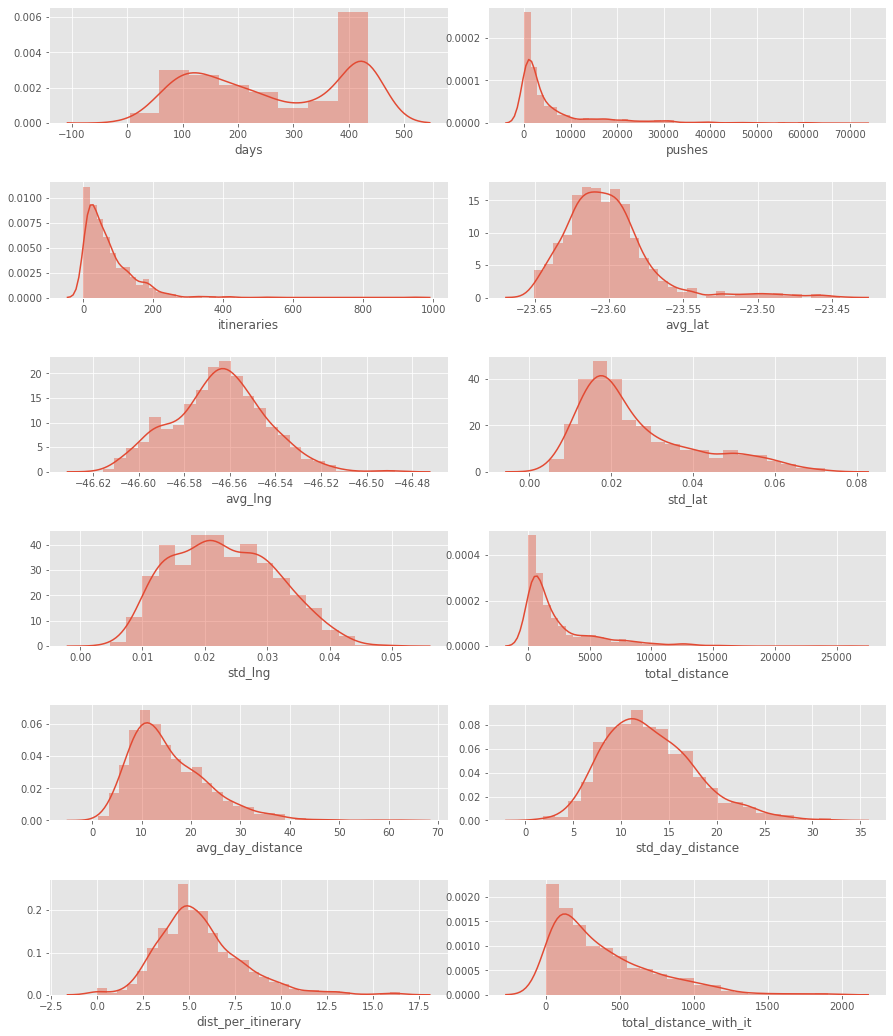

In [251]:
cols = ['days', 'pushes', 'itineraries', 'avg_lat', 'avg_lng', 'std_lat', 'std_lng',
        'total_distance', 'avg_day_distance', 'std_day_distance', 'dist_per_itinerary', 'total_distance_with_it']
fig, axes = plt.subplots(6, 2, figsize=(15,14))
axes = axes.flatten()
for i, col in enumerate(cols):
    sns.distplot(df[col], ax=axes[i])
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.10)

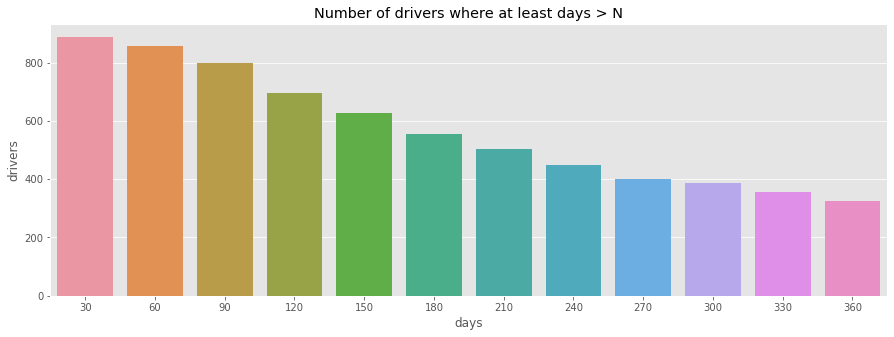

In [252]:
#print('Drivers in available dataset with:')
#for rdays in [(i+1)*30 for i in range(12)]:
#    print('More than {} days: {} ({:0.1f}%)'.format(rdays, sum(df.days > rdays), 100*sum(df.days > rdays)/df.shape[0]))
plt.figure(figsize=(15, 5))
y = [sum(df.days > rdays) for rdays in [(i+1)*30 for i in range(12)]]
x = [rdays for rdays in [(i+1)*30 for i in range(12)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least days > N');
plt.xlabel('days');
plt.ylabel('drivers');

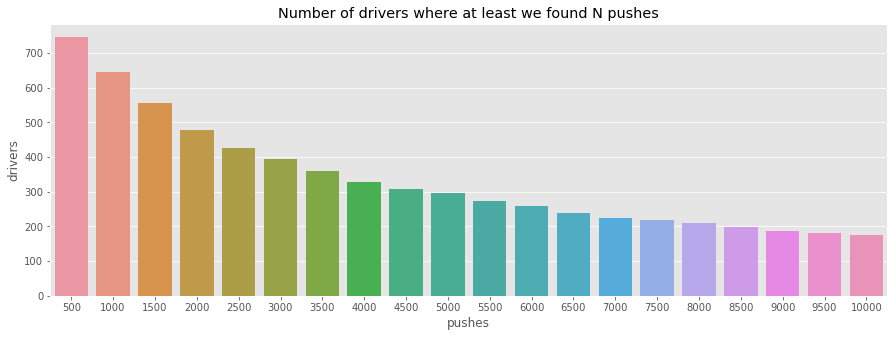

In [253]:
plt.figure(figsize=(15, 5))
y = [sum(df.pushes > p) for p in [(i+1)*500 for i in range(20)]]
x = [p for p in [(i+1)*500 for i in range(20)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least we found N pushes');
plt.xlabel('pushes');
plt.ylabel('drivers');

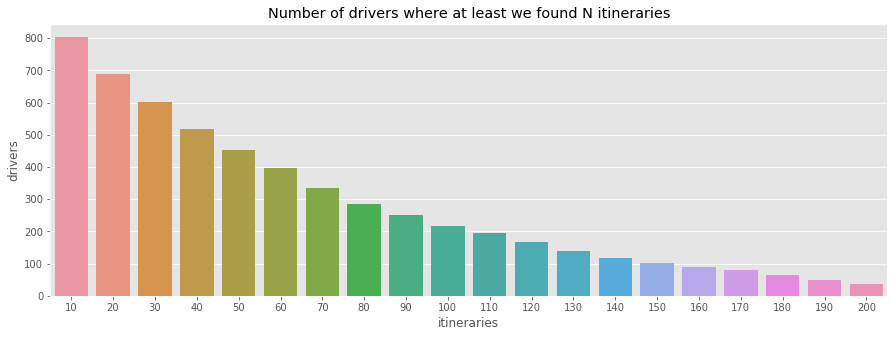

In [254]:
plt.figure(figsize=(15, 5))
y = [sum(df.itineraries > p) for p in [(i+1)*10 for i in range(20)]]
x = [p for p in [(i+1)*10 for i in range(20)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least we found N itineraries');
plt.xlabel('itineraries');
plt.ylabel('drivers');

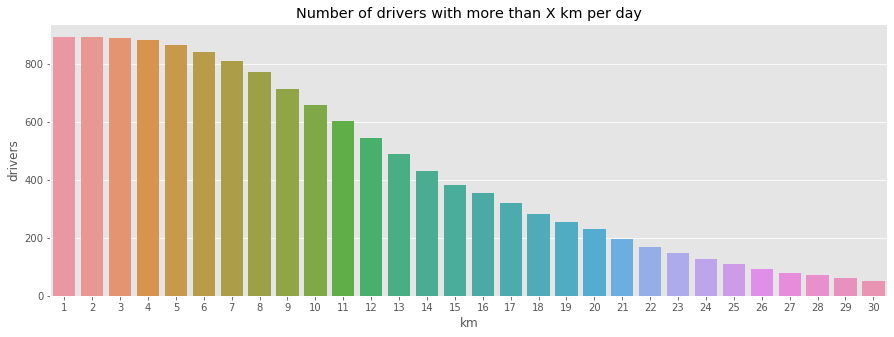

In [255]:
plt.figure(figsize=(15, 5))
y = [sum(df.avg_day_distance > p) for p in [(i+1)*1 for i in range(30)]]
x = [p for p in [(i+1)*1 for i in range(30)]]
sns.barplot(x, y);
plt.title('Number of drivers with more than X km per day');
plt.xlabel('km');
plt.ylabel('drivers');

### Next plot will require an observation in detail

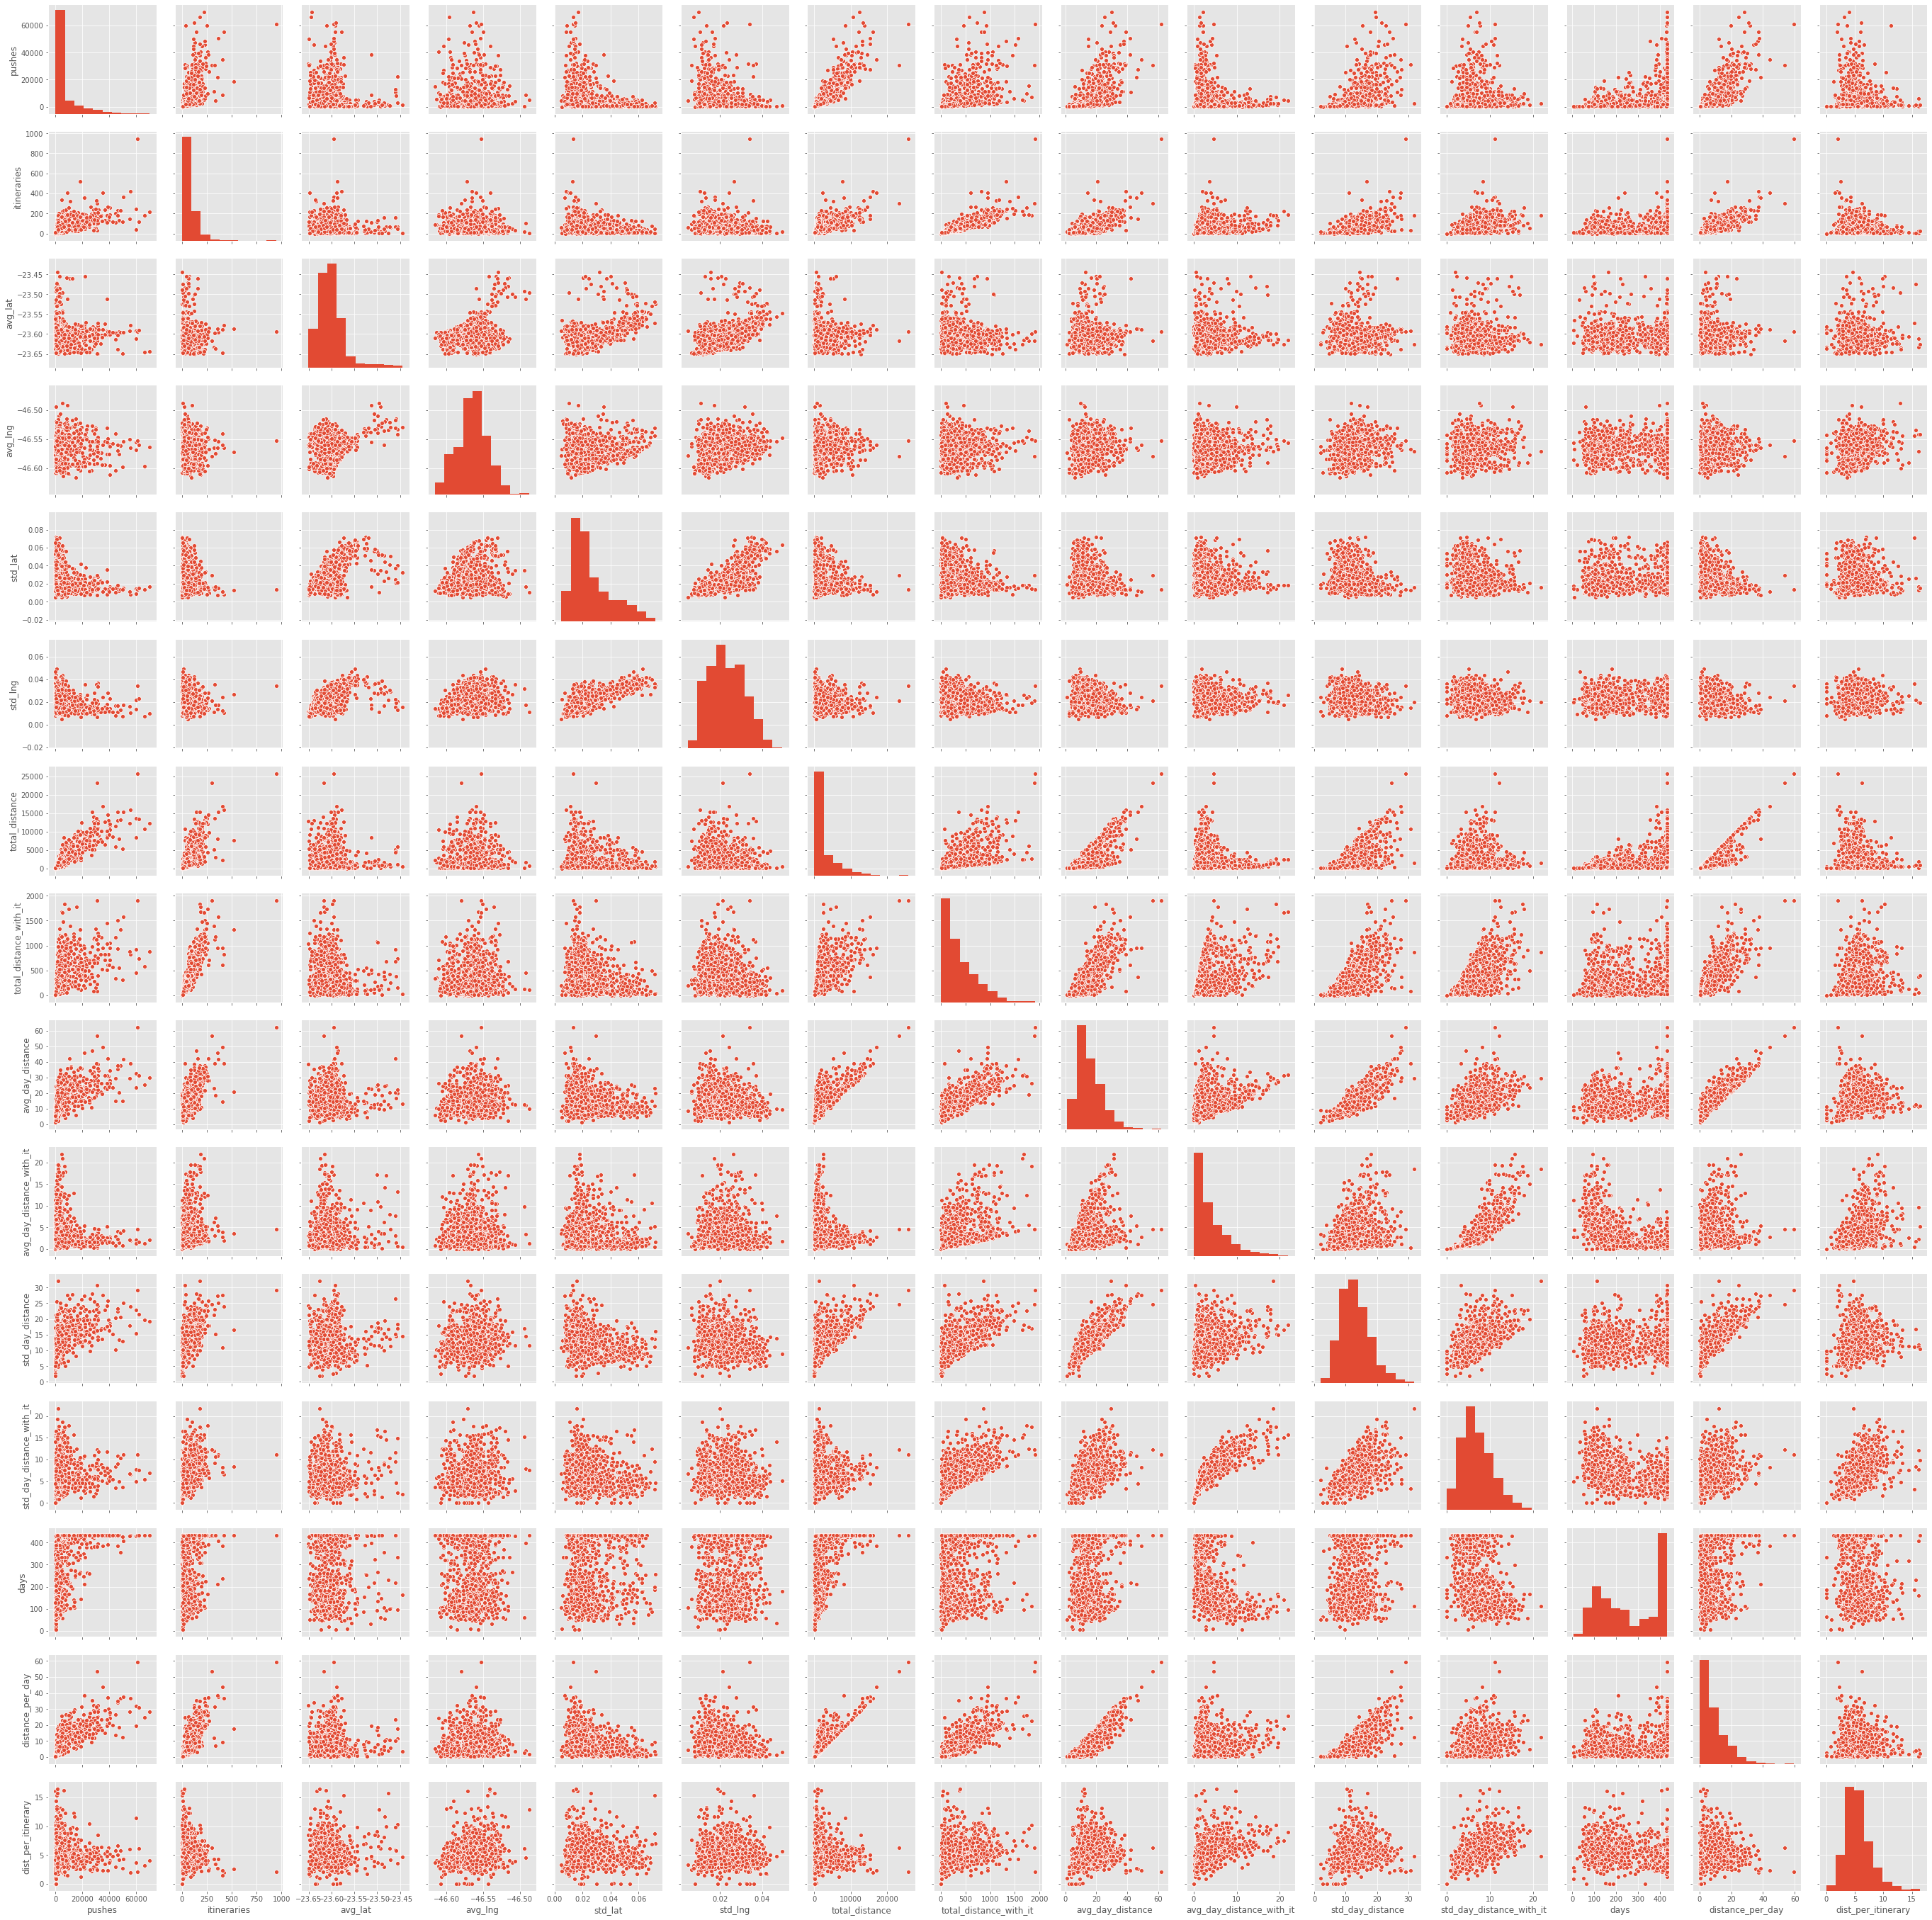

In [256]:
sns.pairplot(data=df);

In [94]:
# we add the latitude and longitude variations
df['near_driver'] = df['std_lat'] + df['std_lng']
df['near_driver'] = df['near_driver'].apply(lambda x: (x - df['near_driver'].mean()) / df['near_driver'].std())
df['near_driver'] = df['near_driver'].abs()
df['near_driver'][df['near_driver'].isna()] = 0
df['near_driver'] = df['near_driver'].astype('int')
df['near_driver'].unique()

<ipython-input-94-17a12691ed4c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([1, 0, 2])

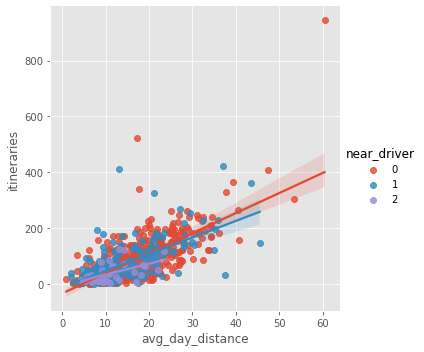

In [96]:
sns.lmplot(x='avg_day_distance', y='itineraries', hue='near_driver', data=df);

### Let see the correlations between the variables

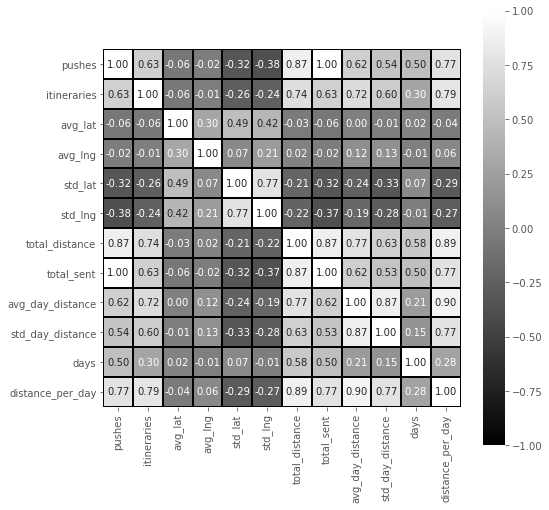

In [85]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

- The number of itineraries is correlated with the number of pushes

### Let's try to plot the avg driver locations

In [86]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    lon = df['avg_lng'].values[:],
    lat = df['avg_lat'].values[:],
    marker = {'size': 5, 'color': 'rgba(255, 100, 100, 0.5)'}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Identify driver by location variance

In [87]:
# we add the latitude and longitude variations
p = df['std_lat'] + df['std_lng']
p = p.apply(lambda x: (x - p.mean()) / p.std())
p = p.abs()
p[p.isna()] = 0
p = p.astype('int')
p.unique()

array([1, 0, 2])

In [88]:
colors = ['rgba(200, 255, 200, 0.7)',
          'rgba(255, 200, 200, 0.7)',
          'rgba(200, 200, 255, 0.7)']

fig = go.Figure()

for s in p.unique():
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        name = '< {} std'.format(s+1),
        lon = df[p == s]['avg_lng'].values[:],
        lat = df[p == s]['avg_lat'].values[:],
        marker = {'size': 5 + s*10, 'color': colors[s]}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Identidy driver by number of itineraries

In [89]:
p = df['itineraries']
groups = [200, 100, 60, 30, 20, 10, 0]
def classify(x):
    for i, s in enumerate(groups):
        if x >= s: return len(groups)-i-1
    assert(1 == 2)
    
p = p.apply(classify)

In [90]:
mc = {0: 'rgba(000, 255, 255, 0.6)',
      1: 'rgba(000, 255, 255, 0.9)',
      2: 'rgba(255, 200, 200, 0.2)',
      3: 'rgba(255, 150, 150, 0.3)',
      4: 'rgba(255, 150, 150, 0.5)',
      5: 'rgba(255, 150, 150, 0.7)',
      6: 'rgba(255, 100, 100, 0.9)'}
#
fig = go.Figure()

groups.sort()

cls = p.unique()
cls.sort()
for c in cls:
    if c != len(groups)-1:
        name = str(groups[c]) + ' - ' + str(groups[c+1])
    else:
        name = '> ' + str(groups[c])
        
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        name = name,
        lon = df[p == c]['avg_lng'].values[:],
        lat = df[p == c]['avg_lat'].values[:],
        marker = {'size': 5 + c*2, 'color': mc[c]}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Driver per KM

In [202]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '<= 10 Km daily',
    lon = df[df.avg_day_distance <= 10]['avg_lng'].values[:],
    lat = df[df.avg_day_distance <= 10]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'red'}))

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '> 10 Km daily',
    lon = df[df.avg_day_distance > 10]['avg_lng'].values[:],
    lat = df[df.avg_day_distance > 10]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'blue'}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

In [97]:
df_wh = careful_query("""
select firstlogin.driver_id, firstlogin.firstlogin, lastlogin.lastlogin, (TO_TIMESTAMP(lastlogin.lastlogin, 'HH24:MI:SS')::TIME) - (TO_TIMESTAMP(firstlogin.firstlogin, 'HH24:MI:SS')::TIME) as workinghours
from firstlogin
inner join lastlogin on  firstlogin.driver_id = lastlogin.driver_id
order by workinghours
""")
df_wh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8195 entries, 0 to 8194
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   driver_id     8195 non-null   object         
 1   firstlogin    8195 non-null   object         
 2   lastlogin     8195 non-null   object         
 3   workinghours  8195 non-null   timedelta64[ns]
dtypes: object(3), timedelta64[ns](1)
memory usage: 256.2+ KB


In [99]:
df = df.merge(df_wh, left_on='driver_id', right_on='driver_id')

In [111]:
df['firstlogin'] = pd.to_datetime(df['firstlogin'])
df['lastlogin'] = pd.to_datetime(df['lastlogin'])

In [133]:
df['total_seconds'] = df.workinghours.apply(lambda x: x.total_seconds())

In [136]:
df['total_hours'] = df['total_seconds']/3600

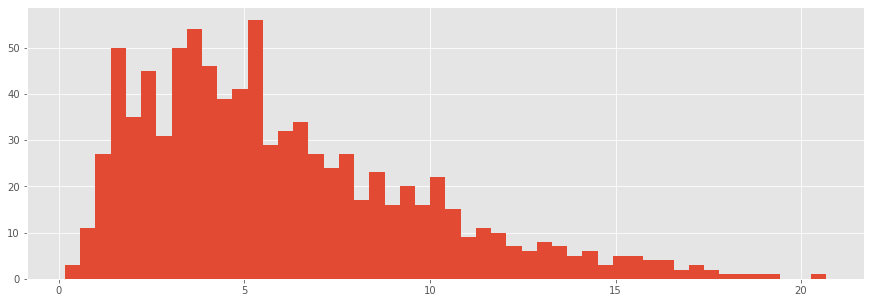

In [137]:
df['total_hours'].hist(bins=50, figsize=(15,5));

In [147]:
df['first_hour'] = df['firstlogin'].apply(lambda x: x.hour)
df['last_hour'] = df['lastlogin'].apply(lambda x: x.hour)

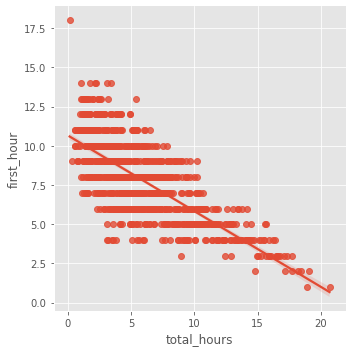

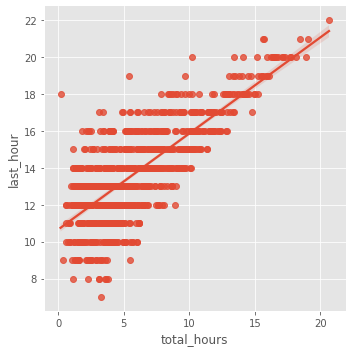

In [151]:
sns.lmplot(x='total_hours', y='first_hour', data=df)
plt.show()
sns.lmplot(x='total_hours', y='last_hour', data=df)

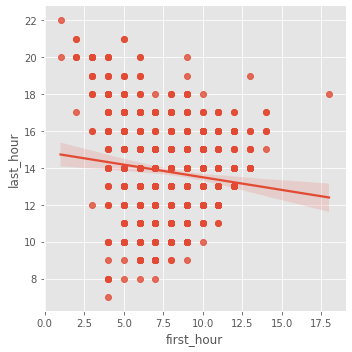

In [159]:
sns.lmplot(x='first_hour', y='last_hour', data=df);

In [172]:
l = [i+3 for i in list(df.first_hour.unique())]
l.sort()
l

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21]

In [173]:
l = [i+3 for i in list(df.last_hour.unique())]
l.sort()
l

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

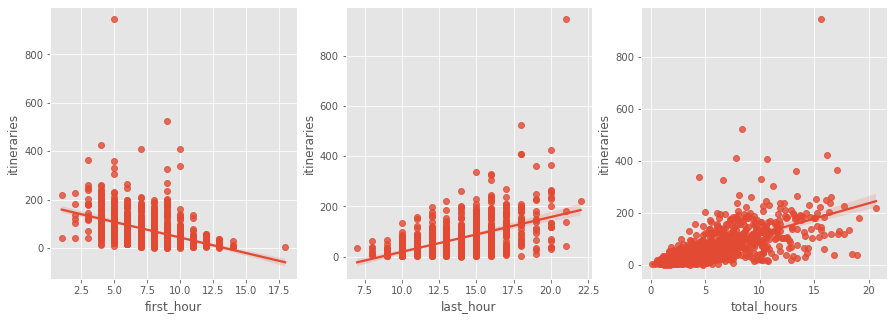

In [186]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, col in enumerate(['first_hour', 'last_hour', 'total_hours']):
    sns.regplot(x=col, y='itineraries', data=df, ax=axes[i]);

In [188]:
df[['first_hour', 'last_hour', 'total_hours']].corr()

first_hour  last_hour  total_hours
first_hour     1.000000  -0.132438    -0.733321
last_hour     -0.132438   1.000000     0.762588
total_hours   -0.733321   0.762588     1.000000

In [183]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '<= 6 working hours',
    lon = df[df.total_hours <= 6]['avg_lng'].values[:],
    lat = df[df.total_hours <= 6]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'red'}))

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    name = '> 6 working hours',
    lon = df[df.total_hours > 6]['avg_lng'].values[:],
    lat = df[df.total_hours > 6]['avg_lat'].values[:],
    marker = {'size': 10, 'color': 'green'}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

In [193]:
tdf = df[['itineraries', 'total_hours', 'pushes']].copy()

In [194]:
tdf['log_itineraries'] = np.log(tdf.itineraries+1)

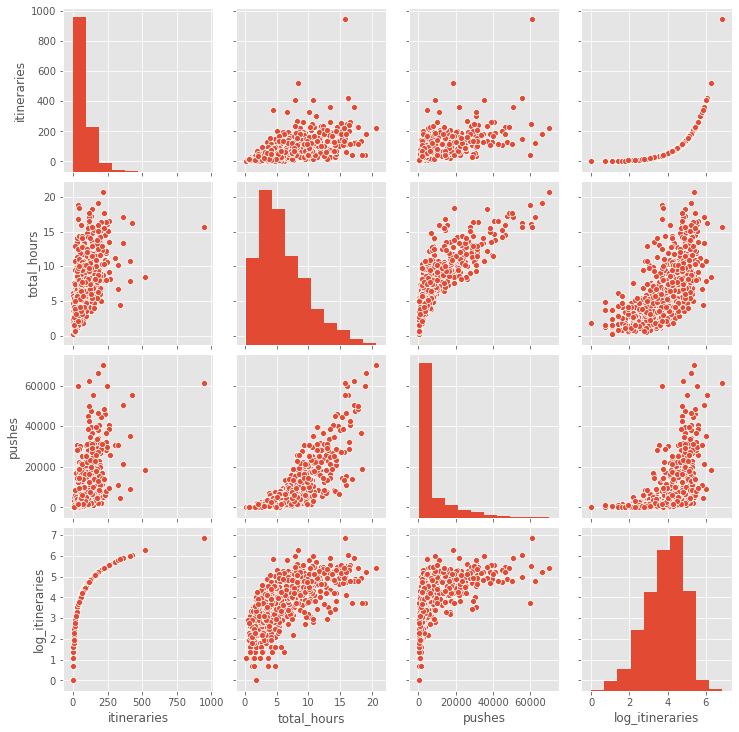

In [196]:
sns.pairplot(tdf);

In [195]:
tdf.corr()

itineraries  total_hours    pushes  log_itineraries
itineraries         1.000000     0.623823  0.630820         0.808742
total_hours         0.623823     1.000000  0.819208         0.655823
pushes              0.630820     0.819208  1.000000         0.541875
log_itineraries     0.808742     0.655823  0.541875         1.000000

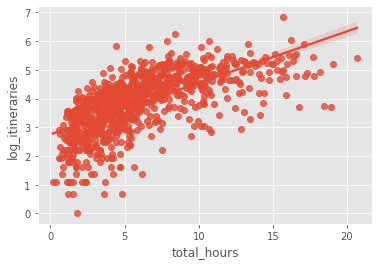

In [200]:
sns.regplot(x='total_hours', y='log_itineraries', data=tdf);